In [19]:
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
import os
from datetime import datetime, timedelta
from pytz import timezone
from dotenv import load_dotenv
from bson import ObjectId
import requests
import logging
from models import User, Reports, db, Organization, BotRecord

load_dotenv()

True

In [17]:
uri = os.getenv("MONGO_URI_PROD")
client = MongoClient(uri, server_api=ServerApi(version="1", strict=True, deprecation_errors=True))

In [30]:
db = client['BlenderProducts']  # Replace with your database name
collection = db['Meetings']  # Replace with your collection name

# List of manager emails
manager_info = {
    "steve.hill@blenderproducts.com": 1,
    "dave.dorste@blenderproducts.com": 3,
    "paul.filby@blenderproducts.com": 2,
    "alex.beeck@blenderproducts.com": 24,
    "ignacio.carrion@blenderproducts.com": 22,
    "mark.pavol@blenderproducts.com": 2,
    "travis.starns@blenderproducts.com": 1,
    "pat.tierney@blenderproducts.com": 2
}

# Date range for November 2024
start_date = datetime(2024, 11, 1)
end_date = datetime(2024, 12, 1)

# Function to convert meeting duration to minutes
def duration_to_minutes(duration_str):
    # Initialize hours, minutes, and seconds
    h, m, s = 0, 0, 0
    
    # Split the duration string and parse each component
    parts = duration_str.split()
    for part in parts:
        if 'h' in part:
            h = int(part.replace('h', ''))
        elif 'm' in part:
            m = int(part.replace('m', ''))
        elif 's' in part:
            s = int(part.replace('s', ''))
    
    return h * 60 + m + s / 60

# Initialize a dictionary to store manager data
manager_data = {}

# Iterate through each manager
for email, employee_count in manager_info.items():
    # Query to filter meetings
    query = {
        "type_name": "One-on-One",
        "date": {"$gte": start_date, "$lt": end_date},
        "attendees": {"$elemMatch": {"email": email, "role": "Manager"}}
    }
    
    # Fetch meetings
    meetings = list(collection.find(query))
    
    # Calculate statistics
    total_meetings = len(meetings)
    total_minutes = sum(duration_to_minutes(meeting['meeting_duration']) for meeting in meetings)
    average_minutes = total_minutes / total_meetings if total_meetings > 0 else 0
    minutes_per_employee = total_minutes / employee_count if employee_count > 0 else 0

   # Store results in the dictionary
    manager_data[email] = {
        "name": email.split('@')[0].replace('.', ' ').title(),  # Convert email to name
        "total_meetings": total_meetings,
        "total_minutes": total_minutes,
        "average_minutes": average_minutes,
        "report_count": employee_count,
        "minutes_per_employee": minutes_per_employee
    }

In [40]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

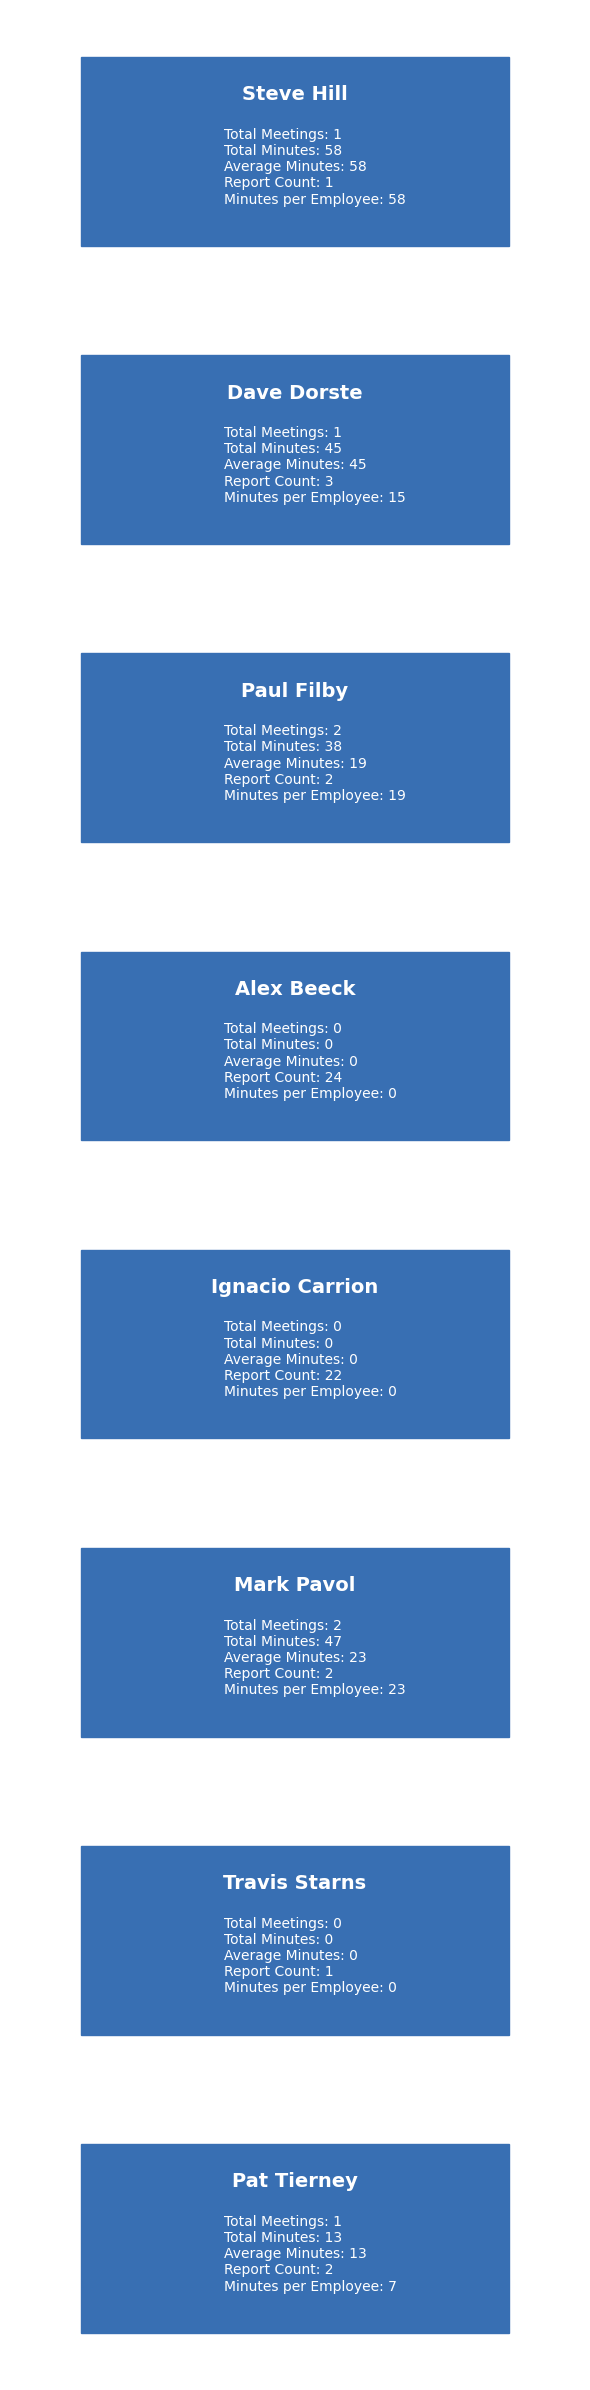

In [56]:
# Visualization settings
card_width = 3
card_height = 2
card_color = "#386fb3"
text_color = "white"

# Create the figure
fig, axes = plt.subplots(len(manager_data), 1, figsize=(6, len(manager_data) * 3))

if len(manager_data) == 1:
    axes = [axes]  # Ensure axes is iterable if there's only one manager

for ax, (email, data) in zip(axes, manager_data.items()):
    # Clear axis
    ax.axis("off")
    # Draw card
    ax.add_patch(Rectangle((0, 0), card_width, card_height, color=card_color))
    
    # Add manager name
    # Add manager name
    ax.text(card_width / 2, card_height * 0.8, data["name"], color=text_color, fontsize=14, fontweight="bold", 
            va="center", ha="center", transform=ax.transData)

    # Add KPIs
    kpi_text = (
        f"Total Meetings: {data['total_meetings']}\n"
        f"Total Minutes: {round(data['total_minutes'])}\n"
        f"Average Minutes: {round(data['average_minutes'])}\n"
        f"Report Count: {round(data['report_count'])}\n"
        f"Minutes per Employee: {round(data['minutes_per_employee'])}"
    )
    ax.text(card_width / 3, card_height / 2.4, kpi_text, color=text_color, fontsize=10, va="center", ha="left", 
            transform=ax.transData)

    # Set limits to fit the card
    ax.set_xlim(-0.5, card_width + 0.5)
    ax.set_ylim(-0.5, card_height + 0.5)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [74]:
import pandas as pd

# Convert manager data to pandas DataFrame
df = pd.DataFrame(manager_data).T


In [75]:
# Drop email and format DataFrame for display
df.reset_index(drop=True, inplace=True)

In [77]:
df["total_minutes"] = df["total_minutes"].astype(int)
df["average_minutes"] = df["average_minutes"].astype(int)
df["minutes_per_employee"] = df["minutes_per_employee"].astype(int)
df.drop(columns=["minutes_per_employee"], inplace=True)


In [78]:
df.rename(columns={"name": "Manager", "total_meetings": "Total Meetings", "total_minutes": "Total Minutes", "average_minutes": "Average Minutes", "report_count": "Report Count"}, inplace=True)

In [79]:
# Define a style function for 0s
def highlight_zeros(val):
    color = "red" if val == 0 else "white"
    return f"color: {color}"

# Apply the style to the DataFrame
styled_df = df.style.applymap(highlight_zeros, subset=["Total Meetings", "Total Minutes", "Average Minutes", "Report Count"])

styled_df

C:\Users\Daniel Hill\AppData\Local\Temp\ipykernel_38964\3195451020.py:7: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.applymap(highlight_zeros, subset=["Total Meetings", "Total Minutes", "Average Minutes", "Report Count"])


,Manager,Total Meetings,Total Minutes,Average Minutes,Report Count
0,Steve Hill,1,57,57,1
1,Dave Dorste,1,45,45,3
2,Paul Filby,2,38,19,2
3,Alex Beeck,0,0,0,24
4,Ignacio Carrion,0,0,0,22
5,Mark Pavol,2,46,23,2
6,Travis Starns,0,0,0,1
7,Pat Tierney,1,13,13,2
